# Evaluating convergence

Here we evaluate the convergence of a trajectory using the clustering ensemble similarity method and the dimensionality reduction ensemble similarity methods.

**Last executed:** Sep 25, 2020 with MDAnalysis 1.0.0

**Last updated:** September 2020

**Minimum version of MDAnalysis:** 1.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests
* [scikit-learn](https://scikit-learn.org/stable/)
   
**Optional packages for visualisation:**

* [matplotlib](https://matplotlib.org)


<div class="alert alert-info">
    
**Note**

The metrics and methods in the `encore` module are from (<a data-cite="tiberti_encore_2015" href="https://doi.org/10.1371/journal.pcbi.1004415">Tiberti *et al.*, 2015</a>). Please cite them when using the ``MDAnalysis.analysis.encore`` module in published work.

</div>

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import encore
from MDAnalysis.analysis.encore.clustering import ClusteringMethod as clm
from MDAnalysis.analysis.encore.dimensionality_reduction import DimensionalityReductionMethod as drm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>)

In [2]:
u = mda.Universe(PSF, DCD)

## Evaluating convergence with similarity measures

The convergence of the trajectory is evaluated by the similarity of the conformation ensembles in windows of the trajectory. The trajectory is divided into windows that increase by `window_size` frames. For example, if your trajectory had 13 frames and you specified a `window_size=3`, your windows would be:

    - Window 1: ---
    - Window 2: ------
    - Window 3: ---------
    - Window 4: -------------
    
Where `-` represents 1 frame.

These are compared using either the similarity of their clusters (`ces_convergence`) or their reduced dimension coordinates (`dres_convergence`). The rate at which the similarity values drop to 0 is indicative of how much the trajectory keeps on resampling the same regions of the conformational space, and therefore is the rate of convergence. 

### Using default arguments with clustering ensemble similarity

See [clustering_ensemble_similarity.ipynb](clustering_ensemble_similarity.ipynb#Calculating-clustering-similarity-with-default-settings) for an introduction to comparing trajectories via clustering.

In [3]:
ces_conv = encore.ces_convergence(u,  # universe
                                  10,  # window size
                                  select='name CA')  # default

The output is an array of similarity values, with the shape (`number_of_windows`, `number_of_clustering_methods`).

In [4]:
ces_conv

array([[0.48194205],
       [0.40284672],
       [0.31699026],
       [0.25220447],
       [0.19829817],
       [0.14642725],
       [0.09911411],
       [0.05667391],
       [0.        ]])

This can be easily plotted as a line.

Text(0, 0.5, 'Jensen-Shannon divergence')

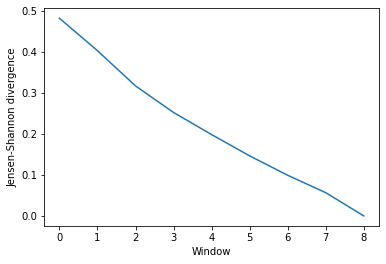

In [5]:
ces_fig, ces_ax = plt.subplots()
plt.plot(ces_conv)
ces_ax.set_xlabel('Window')
ces_ax.set_ylabel('Jensen-Shannon divergence')

### Comparing different clustering methods

You may want to try different clustering methods, or use different parameters within the methods. `encore.ces_convergence` allows you to pass a list of `clustering_methods` to be applied, much like [normal clustering ensemble similarity methods](clustering_ensemble_similarity.ipynb#Calculating-clustering-similarity-with-multiple-methods).

<div class="alert alert-info">
    
**Note**

To use the other ENCORE methods available, you need to install [scikit-learn](https://scikit-learn.org/stable/).

</div>

The KMeans clustering algorithm separates samples into $n$ groups of equal variance, with centroids that minimise the inertia. You must choose how many clusters to partition. [(See the scikit-learn user guide for more information.)](https://scikit-learn.org/stable/modules/clustering.html#k-means)

In [6]:
km1 = clm.KMeans(12,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

km2 = clm.KMeans(6,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

km3 = clm.KMeans(3,  # no. clusters
                 init = 'k-means++',  # default
                 algorithm="auto")    # default

When we pass a list of clustering methods to `encore.ces_convergence`, the similarity values get saved in `ces_conv2` in order.

In [7]:
ces_conv2 = encore.ces_convergence(u,  # universe
                                  10,  # window size
                                  select='name CA',
                                  clustering_method=[km1, km2, km3]
                                 )
ces_conv2.shape

(9, 3)

As you can see, the number of clusters partitioned by KMeans has an effect on the resulting rate of convergence.

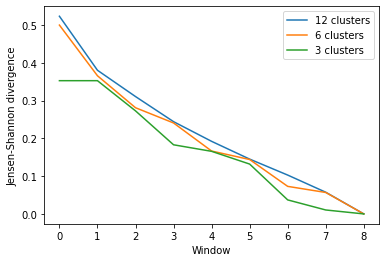

In [8]:
labels = ['12 clusters', '6 clusters', '3 clusters']

ces_fig2, ces_ax2 = plt.subplots()
for data, label in zip(ces_conv2.T, labels):
    plt.plot(data, label=label)
ces_ax2.set_xlabel('Window')
ces_ax2.set_ylabel('Jensen-Shannon divergence')
plt.legend()

### Using default arguments with dimension reduction ensemble similarity

See [dimension_reduction_ensemble_similarity.ipynb](dimension_reduction_ensemble_similarity.ipynb#Calculating-dimension-reduction-similarity-with-default-settings) for an introduction on comparing trajectories via dimensionality reduction.

In [9]:
dres_conv = encore.dres_convergence(u,  # universe
                                  10,  # window size
                                  select='name CA')  # default

Much like `ces_convergence`, the output is an array of similarity values.

In [10]:
dres_conv

array([[0.53259849],
       [0.40801451],
       [0.3137567 ],
       [0.25160251],
       [0.19061233],
       [0.12228127],
       [0.05960165],
       [0.03835858],
       [0.        ]])

Text(0, 0.5, 'Jensen-Shannon divergence')

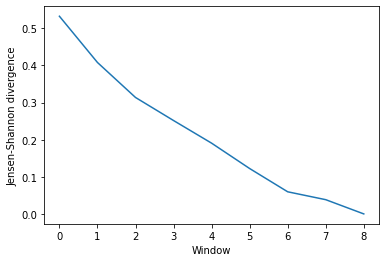

In [11]:
dres_fig, dres_ax = plt.subplots()
plt.plot(dres_conv)
dres_ax.set_xlabel('Window')
dres_ax.set_ylabel('Jensen-Shannon divergence')

### Comparing different dimensionality reduction methods

Again, you may want to compare the performance of different methods.

Principal component analysis uses singular value decomposition to project data onto a lower dimensional space. [(See the scikit-learn user guide for more information.)](https://scikit-learn.org/stable/modules/decomposition.html#pca)

The method provided by MDAnalysis.encore accepts any of the keyword arguments of [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) *except* `n_components`. Instead, use `dimension` to specify how many components to keep.

In [12]:
pc1 = drm.PrincipalComponentAnalysis(dimension=1,
                                     svd_solver='auto')
pc2 = drm.PrincipalComponentAnalysis(dimension=2,
                                     svd_solver='auto')
pc3 = drm.PrincipalComponentAnalysis(dimension=3,
                                     svd_solver='auto')

In [13]:
dres_conv2 = encore.dres_convergence(u,  # universe
                                  10,  # window size
                                  select='name CA',
                                  dimensionality_reduction_method=[pc1, pc2, pc3]
                                 )
dres_conv2.shape

(9, 3)

Again, the size of the subspace you choose to include in your similarity comparison, affects the apparent rate of convergence over the trajectory.

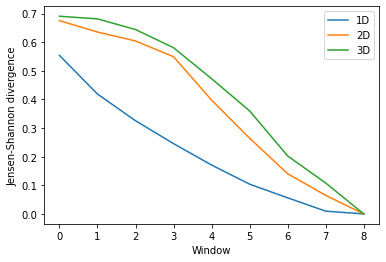

In [14]:
labels = ['1D', '2D', '3D']

dres_fig2, dres_ax2 = plt.subplots()
for data, label in zip(dres_conv2.T, labels):
    plt.plot(data, label=label)
dres_ax2.set_xlabel('Window')
dres_ax2.set_ylabel('Jensen-Shannon divergence')
plt.legend()

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[4] Matteo Tiberti, Elena Papaleo, Tone Bengtsen, Wouter Boomsma, and Kresten Lindorff-Larsen.
<span class="bibtex-protected">ENCORE</span>: <span class="bibtex-protected">Software</span> for <span class="bibtex-protected">Quantitative</span> <span class="bibtex-protected">Ensemble</span> <span class="bibtex-protected">Comparison</span>.
<em>PLOS Computational Biology</em>, 11(10):e1004415, October 2015.
00031.
URL: <a href="https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004415">https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004415</a>, <a href="https://doi.org/10.1371/journal.pcbi.1004415">doi:10.1371/journal.pcbi.1004415</a>.